In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd

In [2]:
# Initialize data for Canada
df = pd.read_csv('Data/covid19-data-Canada.csv', parse_dates=['date'])
populations = [38, 14.7, 8.6, 5.15, 4.4, 1.18, 1.38]
#df.head()

In [3]:
run -i Skeleton.py

Below we take real data for removed in Ontario, Canada
(The real data covers the period between July 17, 2020 and January 8, 2021)

In [4]:
places = {0 : 'Canada', 1: 'Ontario', 2: 'Quebec', 3: 'British Columbia', 4: 'Alberta', 5: 'Saskatchewan', 6: 'Manitoba'}
i = 0
place = places[i]
N = populations[i]*1e6
start, end = 144, 319    # Chosen to match dates analyzed in literature (144, 319)
print ((place))

Canada


In [5]:
Rem, Infec, Susc, t_ont = Canada_init(place)
print(len(Infec))

175


The following can be derived from the SIR model:

 $\log\left(\frac{S(t)}{S(t_s)}\right) = -\frac{R_0}{N}\cdot(R(t)-R(t_s))$     (1)

$R(t) - R(t_s) = \gamma \int_{t_s}^t I(\tau) \mathrm{d}\tau$    (2)

Errors are computed below (95% confidence interval)

In [6]:
lhs1, rhs1, R_0, R_0err, textR_0, res = R_0calculator(Susc)
lhs2, rhs2, gamma, gammaerr, textgamma, res2 = gammacalculator(Rem, Infec)

Genearate SIR model with computed $R_0$, $\gamma$ and $\beta$

In [7]:
print("gamma =", f"{gamma:.6f}", "±", f"{gammaerr:.6f}")
print("R_0 =", textR_0)
beta = gamma*R_0
betaerr = np.sqrt((R_0err/R_0)**2+(gammaerr/gamma)**2)*beta    # not sure this is the way to compute the error in beta
print("beta =", f"{beta:.6f}", "±", f"{betaerr:.6f}, too small?")

gamma = 0.082748 ± 0.000321
R_0 = 1.226262 ± 0.008833
beta = 0.101471 ± 0.000830, too small?


In [39]:
#get data for different scenarios of u and alpha
I0, R0, V0 = Infec[0], Rem[0], 0
S0 = N - I0 - R0 - V0
# Initial conditions vector
y0 = S0, I0, R0, V0
#no vaccines for the first 175 days
t = np.arange(0, 175)
u = 0
alpha = 0
ret = odeint(deriv, y0, t, args=(beta, gamma))
S_bef, I_bef, R_bef, V_bef = ret.T
#vaccines from day 176
I0, R0, V0 = I_bef[-1], R_bef[-1], 0
S0 = N - I0 - R0 - V0
y0 = S0, I0, R0, V0
ret_v = []
t = np.arange(175, 533)
u = [0, 0.5*N/1000, 1*N/1000, 2*N/1000, 0.5*N/1000, 1*N/1000, 2*N/1000]
alpha = [0, 0.95, 0.95, 0.95, 0.60, 0.60, 0.60]
R_aft = []
I_aft = []
ret_final = []
R_final = []
I_final = []
for i in range(7):
    ret_new = odeint(deriv_new, y0, t, args=(beta, gamma))
    ret_v.append(ret_new)
    _, I_dummy, R_dummy, _ = ret_new.T
    R_aft.append(R_dummy)
    I_aft.append(I_dummy)
    
    ret_final.append(np.concatenate((ret, ret_v[i]), axis=0, out=None))
    R_final.append(np.concatenate((R_bef, R_aft[i]), axis=0, out=None))
    I_final.append(np.concatenate((I_bef, I_aft[i]), axis=0, out=None))

In [38]:
print(R_aft[6][-1])

6667980.714045872


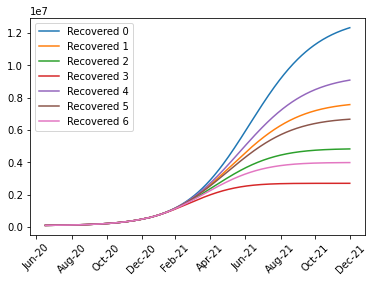

In [40]:
# plot the data obtained in the previous cell
#t = np.arange(0, 533)
#plt.plot(t, R_final[1])
real_t = pd.date_range(start="2020-07-17",end="2021-12-31")
fig, ax = plt.subplots()
for i in range(7):
    
    ax.plot(real_t,R_final[i], label = 'Recovered '+str(i))
date_form = DateFormatter('%b-%y')
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45)
 
plt.legend()
plt.show()